In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing

In [23]:
with open("x28.txt") as file:
    data = []
    content = file.readlines()[72:]
    for line in content:
        line = line.split()
        row = []
        for i in range(1, len(line)):
            row.append(float(line[i]))
        data.append(row)

## Import Data

In [3]:
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,36.0,27.0,71.0,8.1,3.34,11.4,81.5,3243.0,8.8,42.6,11.7,21.0,15.0,59.0,59.0,921.870
1,35.0,23.0,72.0,11.1,3.14,11.0,78.8,4281.0,3.6,50.7,14.4,8.0,10.0,39.0,57.0,997.875
2,44.0,29.0,74.0,10.4,3.21,9.8,81.6,4260.0,0.8,39.4,12.4,6.0,6.0,33.0,54.0,962.354
3,47.0,45.0,79.0,6.5,3.41,11.1,77.5,3125.0,27.1,50.2,20.6,18.0,8.0,24.0,56.0,982.291
4,43.0,35.0,77.0,7.6,3.44,9.6,84.6,6441.0,24.4,43.7,14.3,43.0,38.0,206.0,55.0,1071.289


In [24]:
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.reshape(x.shape[0], 1)

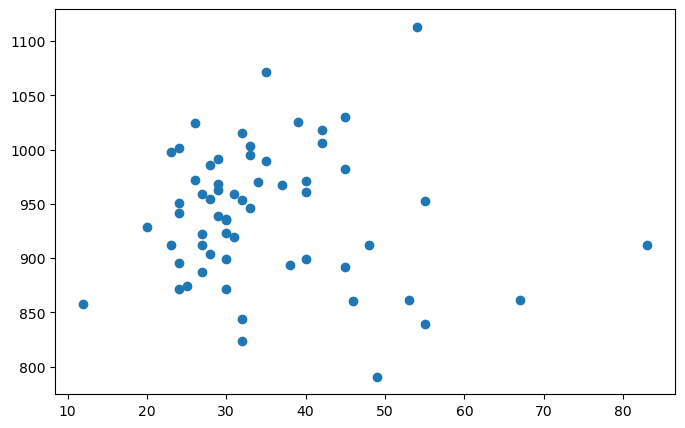

In [5]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(df.iloc[:, 1].values, y);

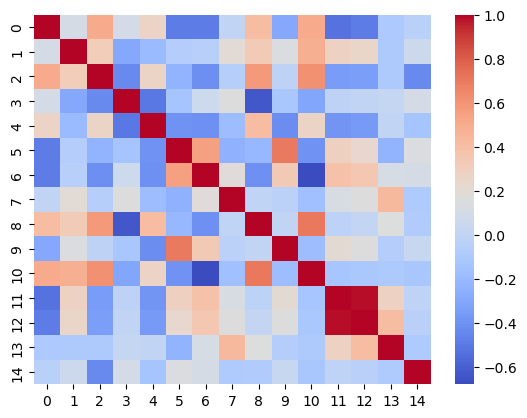

In [6]:
corr = df.iloc[:, :-1].corr()
fig, ax = plt.subplots()
sns.heatmap(corr, cmap = "coolwarm", linecolor = "white");

## Normalize data

In [25]:
def normalize_and_add_ones(x):
    x_max = np.max(x, axis = 0)
    x_min = np.min(x, axis = 0)
    x_normalized = (x - x_min)/(x_max - x_min)
    return np.column_stack((np.ones_like(y), x_normalized))

x = normalize_and_add_ones(x)

# Build model

In [8]:
class RidgeRegression():
    def __init__(self) -> None:
        pass
    def fit(self, x_train, y_train, Lambda):
        assert len(x_train.shape) == 2 and x_train.shape[0] == y_train.shape[0]
        w = np.linalg.inv(x_train.T@x_train + Lambda * np.identity(x_train.shape[1]))@x_train.T@y_train
        return w
    def predict(self, w, x_new):
        y_new = x_new@w
        return y_new
    def compute_RSS(self, y_new, y_predicted):
        loss = 1/y_new.shape[0] * np.sum((y_new - y_predicted)**2)
        return loss
    def get_the_best_Lambda(self, x_train, y_train):
        def cross_validation(num_folds, Lambda):
            # get the indexes of all rows in x_train
            row_ids = np.array(range(x_train.shape[0]))
            # valid end is the last index to get a valid split
            valid_end = len(row_ids) - len(row_ids) % num_folds
            valid_ids_set = np.split(row_ids[:valid_end], num_folds)
            # append all the last rows to valid_ids_set
            valid_ids_set.append(row_ids[valid_end:])
            # i-th training set may contain all index k such that k is not in i-th valid_ids_set
            train_ids_set = []
            for i in range(num_folds):
                ith_set = []
                for k in row_ids:
                    if k not in valid_ids_set[i]:
                        ith_set.append(k)
                train_ids_set.append(ith_set)
            avg_RSS = 0
            for i in range(num_folds):
                w = self.fit(x_train[valid_ids_set[i]], y_train[valid_ids_set[i]], Lambda)
                y_predicted = self.predict(w, x_train[valid_ids_set[i]])
                avg_RSS += self.compute_RSS(y_train[valid_ids_set[i]], y_predicted)
            avg_RSS = avg_RSS/num_folds
            return avg_RSS
        def range_scan(best_Lambda, minimum_RSS, Lambda_values):
            for Lambda in Lambda_values:
                RSS = cross_validation(5, Lambda)
                if RSS < minimum_RSS:
                    best_Lambda = Lambda
                    minimum_RSS = RSS
            return best_Lambda, minimum_RSS
        best_Lambda, minimum_RSS = range_scan(0, np.inf, np.array(range(50)))
        
        # after finding the temperature best_lambda, we continuously scan the small range around best_lambda
        # range = (max(0, best_lambda - 1), best_lambda + 1) with step = 0.001
        start, end, step = max(0, best_Lambda - 1), best_Lambda + 1, 0.001
        Lambda_values = []
        while start <= end:
            Lambda_values.append(start)
            start += step
        best_Lambda, minimum_RSS = range_scan(best_Lambda, minimum_RSS, Lambda_values)
        return best_Lambda
    def fit_minibatch_GD(self, x_train, y_train, Lambda, learning_rate, num_epochs = 100, batch_size = 4):
        m, n = x_train.shape[0], x_train.shape[1]
        w = np.random.randn(n).reshape(n, 1)
        arr = np.array(range(m))
        arr = np.random.shuffle(arr)
        
        epsilon = 1e-8
        num_batch =  m // batch_size
        loss = np.inf
        loss_history = []
        
        for epoch in range(num_epochs):
            for i in range(num_batch + 1):
                index = (batch_size * i)
                x_batch = x_train[index: index + batch_size]
                y_batch = y_train[index: index + batch_size]
                grad = (x_batch.T)@(x_batch@w - y_batch) + Lambda * w
                w -= learning_rate * grad
            new_loss = self.compute_RSS(y_train, x_train@w)
            loss_history.append(new_loss)
            if abs(new_loss - loss) < epsilon:
                break
            loss = new_loss
        return w, loss_history
    def fit_SGD(self, x_train, y_train, Lambda, learning_rate, num_epochs):
        return fit_minibatch_GD(x_train, y_train, Lambda, learning_rate, num_epochs = 100, batch_size = 1)

In [16]:
def analysis_result(w, x_train, y_train, model = RidgeRegression()):
    best_Lambda = model.get_the_best_Lambda(x_train, y_train)
    print("=========== Best found LAMBDA ===========")
    print("LAMBDA = ", best_Lambda)
    print("============= Weights found =============")
    print("W = ", w)
    print("============ On training set ============")
    y_pred = model.predict(w, x_train)
    RSS = model.compute_RSS(y_train, y_pred)
    print("RSS = ", RSS)
    print("============ On test set ================")
    y_pred = model.predict(w, x_test)
    RSS = model.compute_RSS(y_test, y_pred)
    print("RSS =", RSS)
    print("=========== Predicted label =============")
    print("Predicted Y =", y_pred)

In [20]:
x_train, y_train = x[:50], y[:50]
x_test, y_test = x[50:], y[50:]
ridge_regression = RidgeRegression()
best_Lambda = ridge_regression.get_the_best_Lambda(x_train, y_train)
w = ridge_regression.fit(x_train, y_train, Lambda = best_Lambda)
analysis_result(w, x_train, y_train)

=========== Best found LAMBDA ===========
LAMBDA =  0.001
============= Weights found =============
W =  [[1033.60165053]
 [  98.10277364]
 [-180.99935526]
 [ -50.46072063]
 [-115.67203136]
 [ -87.90105798]
 [ -80.9610377 ]
 [ -22.18991587]
 [ 107.22328658]
 [ 111.87406757]
 [  27.32033722]
 [  33.35049819]
 [-518.82384133]
 [ 536.37558041]
 [  -3.51425522]
 [  23.33503946]]
============ On training set ============
RSS =  675.5551063261288
============ On test set ================
RSS = 1550.7460312815356
=========== Predicted label =============
Predicted Y = [[876.29184193]
 [920.3726401 ]
 [932.73209986]
 [892.8995198 ]
 [991.55669706]
 [895.7924415 ]
 [932.14386414]
 [889.55163965]
 [911.33139421]
 [923.14444653]]


In [21]:
m = x_train.shape[0]
W, loss_history = ridge_regression.fit_minibatch_GD(x_train, y_train,
                                        Lambda = best_Lambda,
                                        num_epochs=1000,
                                        learning_rate = 0.03,
                                        batch_size=8)
analysis_result(W, x_train, y_train)

=========== Best found LAMBDA ===========
LAMBDA =  0.001
============= Weights found =============
W =  [[ 942.3921462 ]
 [ 116.21000866]
 [-159.0339278 ]
 [ -39.80753979]
 [ -66.99180274]
 [ -49.0955667 ]
 [ -56.61024492]
 [ -24.10821155]
 [  98.4289939 ]
 [ 118.25419631]
 [  32.538647  ]
 [  36.78411955]
 [ -65.07608222]
 [  89.32073298]
 [  52.51167979]
 [  22.24835517]]
============ On training set ============
RSS =  770.1226208242141
============ On test set ================
RSS = 1442.3192560947646
=========== Predicted label =============
Predicted Y = [[ 884.02733766]
 [ 927.81355875]
 [ 923.02799603]
 [ 902.86816556]
 [1007.25411719]
 [ 884.31883687]
 [ 934.43043948]
 [ 905.2952997 ]
 [ 909.37815761]
 [ 924.90780654]]


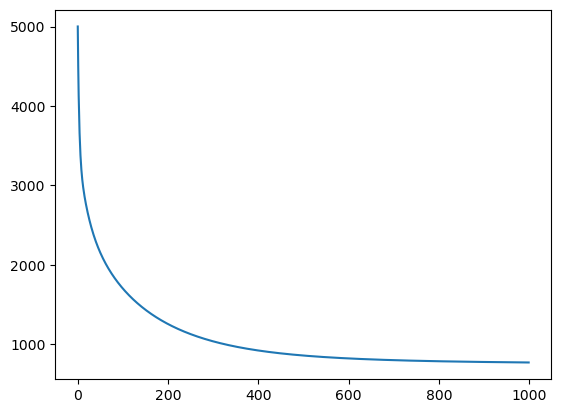

In [22]:
plt.plot(loss_history)